# Organelle image classification

## 1. Introduction

This project aims to reach protein classification through advanced image analysis techniques. The primary objective is to create a machine learning model capable of predicting the presence of specific proteins within a given image, addressing the complexity of a multi-label classification challenge. The metric of choice for assessing model performance is the mean F1-score, ensuring precision and recall are both accounted for.

## 2. Loading the data

In [1]:
# This notebook is meant to run on Google Colab. This requires some additional installations and upgrades.
!pip install torch-summary --upgrade
!pip install timm
!pip install -q kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.9 MB/s eta 0:00:00


In [1]:
# Loading packages
from torchsummary import summary
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision import models
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import multilabel_confusion_matrix

In [3]:
# Retrieve kaggle dataset.
files.upload() # Upload kaggle json, downloaded from the kaggle page.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle competitions download -c cellular-protein-localization-prediction-challenge

! unzip cellular-protein-localization-prediction-challenge.zip
! rm cellular-protein-localization-prediction-challenge.zip # Remove original zip file

Streaming output truncated to the last 5000 lines.
  inflating: train/28913.png         
  inflating: train/28914.png         
  inflating: train/28915.png         
  inflating: train/28916.png         
  inflating: train/28917.png         
  inflating: train/28919.png         
  inflating: train/2892.png          
  inflating: train/28920.png         
  inflating: train/28922.png         
  inflating: train/28924.png         
  inflating: train/28931.png         
  inflating: train/28934.png         
  inflating: train/28937.png         
  inflating: train/28938.png         
  inflating: train/28939.png         
  inflating: train/28940.png         
  inflating: train/28941.png         
  inflating: train/28943.png         
  inflating: train/28949.png         
  inflating: train/2895.png          
  inflating: train/28950.png         
  inflating: train/28953.png         
  inflating: train/28954.png         
  inflating: train/28957.png         
  inflating: train/28958.png         

In [2]:
# Paths
train_data_dir = "./train"
train_csv = "./train.csv"

test_data_dir = "./test"
test_csv = "./submission.csv"

In [45]:
# Load the csv file files as pd dataframes
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

In [44]:
# Prepare the label dictionary
labels = {
    0: "Mitochondria",
    1: "Nuclear bodies",
    2: "Nucleoli",
    3: "Golgi apparatus",
    4: "Nucleoplasm",
    5: "Nucleoli fibrillar center",
    6: "Cytosol",
    7: "Plasma membrane",
    8: "Centrosome",
    9: "Nuclear speckles",
}

# 3. Data exploration

In [47]:
display(train_df.head(10))

,Image,Label
0,12874,1 4
1,21466,0
2,3610,4
3,2095,2 4
4,28909,4
5,21570,3
6,30580,4
7,8077,4
8,9642,4 6
9,1918,4


The labels are correctly loaded as a dataframe, each image has a series of associated labels, delimited by spaces.

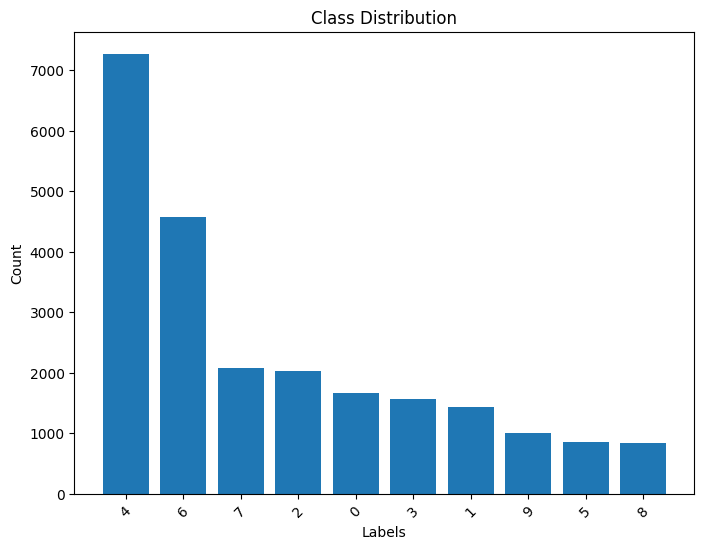

In [6]:
# Visualise class distribution

label_counts = {}
flat_label_list = []
for values in train_df["Label"]:
    label_list = values.split()
    for label in label_list:
        flat_label_list.append(label)
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1


sorted_label_counts = {
    k: v
    for k, v in sorted(label_counts.items(), key=lambda item: item[1], reverse=True)
}

plt.figure(figsize=(8, 6))
plt.bar(sorted_label_counts.keys(), sorted_label_counts.values())
plt.title("Class Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

There is noticable class imbalance, 4 and 6 (Golgi apparatus and Nucleoplasm) have a much larger occurrence than the other classes.

There are two possible solutions:
1) Weights will be calculated and a weighted loss function will be used that assigns higher weights to minority class samples during training.
2) Oversampling- and undersampling techniques can be applied to handle imbalanced classes effectively.

The methods return slighly different results, both have their own benefits and downsides.

For this analysis, method 1 will be performed.

In [7]:
# Calculate weights
unique_labels = set(str(key) for key in labels.keys())
unique_labels = sorted(list(unique_labels))

class_weights = compute_class_weight(
    "balanced", classes=unique_labels, y=flat_label_list
)
weights_dict = {i: class_weights[i] for i in range(10)}
print("Class weights:", weights_dict)

Class weights: {0: 1.3986194477791116, 1: 1.6294405594405594, 2: 1.1506666666666667, 3: 1.4936538461538462, 4: 0.3203767358724048, 5: 2.7125727590221187, 6: 0.5094228246611281, 7: 1.1251086431675519, 8: 2.787200956937799, 9: 2.3139026812313803}


As we can see, more abundant classes 4 and 6 now carry lower weights.

Applying the weights corresponds to giving more penalty to the classes with more weight and vice versa.

In [8]:
# Explore image characteristics
sample_image = Image.open("./train/0.png")

print("Sample Image Information:")
print(f"Image Size: {sample_image.size}")
print(f"Image Mode: {sample_image.mode}")

Sample Image Information:
Image Size: (128, 128)
Image Mode: RGB


As expected, the image has RGB values that will be represented by the 3 channels in our NN.

The images have a rather low resolution (128x128), this will reduce computational intensity but throttle the results.

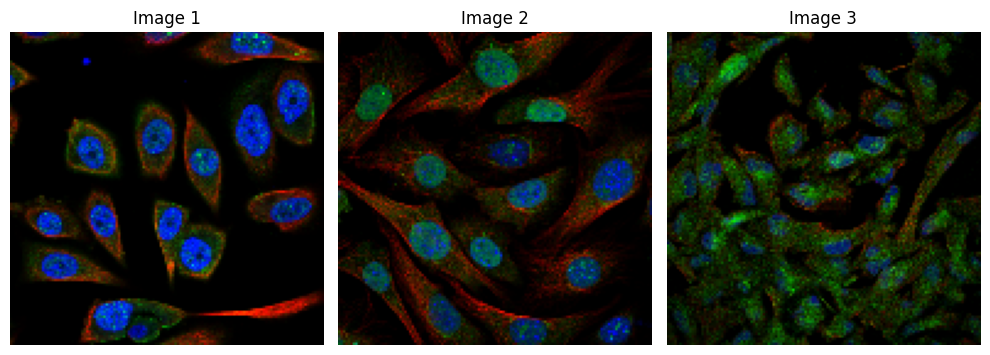

In [9]:
# Preview (enlarged) images
sample_image2 = Image.open("./train/1.png")
sample_image3 = Image.open("./train/3.png")

sample_image.resize((256, 256))
sample_image2.resize((256, 256))
sample_image3.resize((256, 256))

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(sample_image)
plt.title("Image 1")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(sample_image2)
plt.title("Image 2")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(sample_image3)
plt.title("Image 3")
plt.axis("off")

plt.tight_layout()
plt.show()

The images originate from fluorescence microscopy, resulting in RGB values with high intensities and a black background.

In [10]:
# Check for missing values in the dataset
missing_labels = train_df["Label"].isnull().sum()
print("Number of missing labels:", missing_labels)

Number of missing labels: 0


There are no missing values in the dataset.

# 4. Preprocessing

In [11]:
# In order to transform the labels to a tensor that can be used for training, we encode them to a tensor, using one-hot-encoding.
def encode_label(label: str):
    target = torch.zeros(10) # Initialize a tensor of 10 zeros
    for l in str(label).split(" "):
        target[int(l)] = 1.0
    return target

In [12]:
# Function to decode the encoded labels back to its original format
def decode_target(
    target: torch.Tensor, text_labels: bool = False, threshold: float = 0.5
):
    result = []
    for i, x in enumerate(target):
        if x >= threshold:
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return " ".join(result)

In [13]:
# Convert class_weights dictionary to a tensor
class_weights_tensor = torch.tensor(
    [class_weights[i] for i in range(len(class_weights))], dtype=torch.float
)

In [14]:
# To normalize the data, we need to calculate the means and stdevs per channel for the images
mean_per_channel = [0.0, 0.0, 0.0]
std_per_channel = [0.0, 0.0, 0.0]

# Iterate over all images in the dataset directory
count = 0
for filename in os.listdir(train_data_dir):
    img = Image.open(os.path.join(train_data_dir, filename))
    img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]

    # Calculate per-channel mean
    mean_per_channel[0] += np.mean(img[:, :, 0])
    mean_per_channel[1] += np.mean(img[:, :, 1])
    mean_per_channel[2] += np.mean(img[:, :, 2])

    # Calculate per-channel stdev
    std_per_channel[0] += np.std(img[:, :, 0])
    std_per_channel[1] += np.std(img[:, :, 1])
    std_per_channel[2] += np.std(img[:, :, 2])

    count += 1

# Calculate the mean and standard deviation across all images
total_images = len(os.listdir(train_data_dir))
mean_per_channel = [m / total_images for m in mean_per_channel]
std_per_channel = [s / total_images for s in std_per_channel]

print("Mean per channel:", mean_per_channel)
print("Standard deviation per channel:", std_per_channel)

Mean per channel: [0.07819786874680702, 0.05209000149719692, 0.05402339364832609]
Standard deviation per channel: [0.11591775167397322, 0.07654528936568677, 0.13421668103375878]


We will later normalize the values based on the means and stdevs per channel. This helps ensure that the pixel values of the images are within a consistent range, making it easier for the network to learn patterns.

# 5. Convolutional Neural Networks

In [15]:
# Check if cuda cores are available for faster computations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# PyTorchDataset that will ease the training process and can be used later for the DataLoader:

class ProteinDataset(Dataset):
    def __init__(self, dataframe, data_dir="./train", transform=None, mode="train"):
        self.data = dataframe
        self.transform = transform
        self.data_dir = data_dir
        self.mode = mode  # 'train' or 'test'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.mode == "train":
            img_name = os.path.join(self.data_dir, str(self.data.iloc[idx, 0]) + ".png")
            image = Image.open(img_name)
            label = encode_label(self.data.iloc[idx, 1])

            if self.transform:
                image = self.transform(image)

            return image, label
        elif self.mode == "test":
            img_name = os.path.join(self.data_dir, str(self.data.iloc[idx, 0]) + ".png")
            image = Image.open(img_name)

            if self.transform:
                image = self.transform(image)

            return image, self.data.iloc[idx, 0]  # Return image name for test mode
        else:
            raise ValueError("Invalid mode. Use 'train' or 'test'.")

In [17]:
# Transformations
transforms_train = transforms.Compose(
    [
        transforms.Resize((128, 128)),  # Resize images to 128x128 pixels if needed (sanity measure)
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.RandomVerticalFlip(),  # Randomly flip images vertically
        transforms.RandomRotation(degrees=15), # Randomly rotate images
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_per_channel, std=std_per_channel), # Normalize the RGB values
    ]
)

These transformations are performed to augment the dataset, introducing variations like flips and rotations to increase diversity in the training images. Resizing to a standard size ensures uniformity, while normalization maintains consistent RGB value ranges for effective model training.

Ultimately, these measures will make the model more generalizable and reduce overfitting.

Cropping the images and removing background noise are unnecessary measures as the images are already focused on the organelles of interest and there is no background noise to remove.

In [18]:
# Split data into training and validation dataset
train_size = int(0.8 * len(train_df))
val_size = len(train_df) - train_size
train_dataset, val_dataset = train_test_split(train_df, test_size=val_size)

# Create dataloader objects:

# Training dataset
train_loader = DataLoader(
    ProteinDataset(train_dataset, transform=transforms_train),
    batch_size=32, # Batch size has to be a power of 2, 32 is generally the best trade-off between training time, overfitting,...
    shuffle=True, # Shuffle for randomisation
    pin_memory=True if device == "cuda" else False  # Pin memory if using CUDA, this lets the data loader allocate the samples in page-locked memory, which speeds-up the transfer.
)

# Validation dataset
val_loader = DataLoader(
    ProteinDataset(val_dataset, transform=transforms_train),
    batch_size=32,
    shuffle=False, # Shuffle is not necessary for the validation dataset
    pin_memory=True if device == "cuda" else False
)


In [19]:
# Convert class_weights dictionary to a tensor
class_weights_tensor = torch.tensor(
    [class_weights[i] for i in range(len(class_weights))], dtype=torch.float
)

## Densenet121

We will begin our analysis using the pretrained Densenet121 model. According to benchmarks presented in a related research paper addressing a similar research question, Densenet121 offers a favorable balance between computational efficiency and performance metrics.

[Paper link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8331148/)

In [20]:
class ProteinDenseNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ProteinDenseNet, self).__init__()
        self.densenet = models.densenet121(pretrained=True) # We will use pretrained densenet from the pytorch models repo.
        # Modify the last fully connected layer to output the number of classes
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.densenet(x)

Adding another dropout layer for regularization is redundant because the pretrained Densenet model architecture already includes dropout layers during training. These layers serve the purpose of regularization by randomly dropping neurons' outputs, reducing overfitting and improving generalization.

The addition of ReLU (Rectified Linear Unit) after the first linear layer is to introduce non-linearity, allowing the network to learn complex features effectively. ReLU is a common activation function that introduces non-linearity by mapping negative values to zero while keeping positive values unchanged, enabling better representation learning.

The final layer uses the Sigmoid activation function, which is suitable for multi-label classification tasks. It squashes the model's output between 0 and 1, providing probabilities for each class independently, allowing for multiple classes to be predicted for a given input image.

In [21]:
# Initialize the model
model = ProteinDenseNet().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
# Overview of the model
summary(model)

Layer (type:depth-idx)                   Param #
├─DenseNet: 1-1                          --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  9,408
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─MaxPool2d: 3-4               --
|    |    └─_DenseBlock: 3-5             335,040
|    |    └─_Transition: 3-6             33,280
|    |    └─_DenseBlock: 3-7             919,680
|    |    └─_Transition: 3-8             132,096
|    |    └─_DenseBlock: 3-9             2,837,760
|    |    └─_Transition: 3-10            526,336
|    |    └─_DenseBlock: 3-11            2,158,080
|    |    └─BatchNorm2d: 3-12            2,048
|    └─Sequential: 2-2                   --
|    |    └─Linear: 3-13                 524,800
|    |    └─ReLU: 3-14                   --
|    |    └─Linear: 3-15                 5,130
|    |    └─Sigmoid: 3-16                --
Total params: 7,483,786
Trainable params: 7,483,786
Non-traina

Layer (type:depth-idx)                   Param #
├─DenseNet: 1-1                          --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  9,408
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─MaxPool2d: 3-4               --
|    |    └─_DenseBlock: 3-5             335,040
|    |    └─_Transition: 3-6             33,280
|    |    └─_DenseBlock: 3-7             919,680
|    |    └─_Transition: 3-8             132,096
|    |    └─_DenseBlock: 3-9             2,837,760
|    |    └─_Transition: 3-10            526,336
|    |    └─_DenseBlock: 3-11            2,158,080
|    |    └─BatchNorm2d: 3-12            2,048
|    └─Sequential: 2-2                   --
|    |    └─Linear: 3-13                 524,800
|    |    └─ReLU: 3-14                   --
|    |    └─Linear: 3-15                 5,130
|    |    └─Sigmoid: 3-16                --
Total params: 7,483,786
Trainable params: 7,483,786
Non-traina

The resulting model comprises several convolutional, batch normalization, ReLU activation, max-pooling, and transition layers within the DenseNet blocks. The last layers include a modified fully connected block with two linear (fully connected) layers, utilizing ReLU activation for the first linear layer and Sigmoid activation for the final layer, specifically designed for handling multiple labels in the classification task.

The model has a total of 7,483,786 trainable parameters, inheriting the pre-trained weights from DenseNet121 and introducing additional trainable parameters in the modified fully connected layers for the specific task.

In [23]:
# Define a function for the f1-score, as this will be the metric of importance
def calculate_f1_score(predictions, labels, threshold=0.5):
    predictions = (predictions > threshold).float()
    tp = (predictions * labels).sum(dim=0)
    fp = (predictions * (1 - labels)).sum(dim=0)
    fn = ((1 - predictions) * labels).sum(dim=0)

    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)

    f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
    f1 = f1.mean()

    return f1.item()

In [24]:
# Initialize lists to store metrics and labels for later visualisations.
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []
lr_values = []

In [48]:
# Define the criterion, optimizer and learning rate scheduler
criterion = nn.BCELoss(weight= class_weights_tensor).to(device)  # Criterion moved to device, Binary Cross Entropy Loss for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.0001) # Adaptive Moment Estimation optimizer, learning rate 0.001
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, verbose=True)

For the loss function, Binary Cross Entropy is chosen as the criterion for multi-label classification because it effectively handles situations where each instance can belong to multiple classes.

ReduceLROnPlateau scheduler is chosen to regulate learning rate based on performance improvements instead of a static learning rate.

In [27]:
# Early stopping
best_val_loss = float('inf') # Placeholder
patience = 10  # Define patience - number of epochs without improvement to tolerate
counter = 0  # Counter to keep track of epochs without improvement

best_model_path = 'best_model.pth'

Early stopping is implemented to avoid redundant computations.

In [28]:
num_epochs = 40
# Iterate through each epoch
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize loss for the epoch
    running_f1 = 0.0  # Initialize F1 score for the epoch

    # Iterate through the training data
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()  # Clear previous gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()  # Accumulate loss for the epoch
        f1_batch = calculate_f1_score(outputs, labels)  # Calculate F1 score for the batch
        running_f1 += f1_batch  # Accumulate F1 score

    # Calculate average training loss and F1 score for the epoch
    avg_train_loss = running_loss / len(train_loader)
    avg_train_f1 = running_f1 / len(train_loader)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Initialize validation loss
    val_f1 = 0.0  # Initialize validation F1 score

    # Disable gradient calculation for validation
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Forward pass
            val_loss += criterion(outputs, labels).item()  # Accumulate validation loss
            f1_batch = calculate_f1_score(outputs, labels)  # Calculate F1 score for the batch
            val_f1 += f1_batch  # Accumulate validation F1 score

    # Calculate average validation loss and F1 score
    avg_val_loss = val_loss / len(val_loader)
    avg_val_f1 = val_f1 / len(val_loader)

    # Print epoch-wise metrics
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, Train F1: {avg_train_f1:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val F1: {avg_val_f1:.4f}")

    # Record metrics for visualization
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_f1_scores.append(avg_train_f1)
    val_f1_scores.append(avg_val_f1)
    lr_values.append(optimizer.param_groups[0]['lr'])  # Record learning rate

    scheduler.step(avg_val_loss)  # Adjust learning rate based on validation loss

    # Early stopping mechanism
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss  # Update best validation loss
        counter = 0  # Reset counter for consecutive epochs without improvement
        torch.save(model.state_dict(), best_model_path)  # Save current best model
    else:
        counter += 1  # Increment counter for consecutive epochs without improvement
        if counter >= patience:  # Check if reached the patience limit
            print(f'Early stopping: No improvement for {patience} consecutive epochs.')
            break  # End training loop if no improvement for 'patience' epochs

Epoch 1/40, Train Loss: 0.3264, Train F1: 0.1760, Val Loss: 0.2918, Val F1: 0.2566
Epoch 2/40, Train Loss: 0.2771, Train F1: 0.3125, Val Loss: 0.2666, Val F1: 0.3369
Epoch 3/40, Train Loss: 0.2589, Train F1: 0.3760, Val Loss: 0.2659, Val F1: 0.3744
Epoch 00003: reducing learning rate of group 0 to 5.0000e-05.
Epoch 4/40, Train Loss: 0.2393, Train F1: 0.4278, Val Loss: 0.2539, Val F1: 0.4149
Epoch 5/40, Train Loss: 0.2280, Train F1: 0.4666, Val Loss: 0.2485, Val F1: 0.4308
Epoch 00005: reducing learning rate of group 0 to 2.5000e-05.
Epoch 6/40, Train Loss: 0.2173, Train F1: 0.4877, Val Loss: 0.2423, Val F1: 0.4556
Epoch 7/40, Train Loss: 0.2101, Train F1: 0.5083, Val Loss: 0.2451, Val F1: 0.4526
Epoch 00007: reducing learning rate of group 0 to 1.2500e-05.
Epoch 8/40, Train Loss: 0.2016, Train F1: 0.5224, Val Loss: 0.2410, Val F1: 0.4671
Epoch 9/40, Train Loss: 0.1985, Train F1: 0.5362, Val Loss: 0.2435, Val F1: 0.4713
Epoch 00009: reducing learning rate of group 0 to 6.2500e-06.
Epoch

This codeblock represents a typical training loop for a neural network, including training and validation phases, tracking metrics, applying learning rate scheduling, and implementing early stopping to prevent overfitting.

# 6. Evaluation

In [29]:
model.eval()  # Sets the model to evaluation mode, disabling dropout and batch normalization
correct = 0
total = 0
threshold = 0.5  # Defines the threshold for prediction probabilities to determine binary predictions

# Initialize empty lists for tracking
true_labels = []
predicted_labels = []
predicted_probs = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        # Apply the defined threshold to convert probabilities to binary predictions
        predicted = (outputs > threshold).float()

        # Extend lists with label information
        true_labels.extend(labels.cpu().numpy())  # Collect true labels
        predicted_labels.extend(predicted.cpu().numpy())  # Collect predicted labels

        # Compute total and correct predictions
        total += labels.size(0) * labels.size(1)  # Total number of elements in the batch
        correct += (predicted == labels).sum().item()  # Count correct predictions

        predicted_probs.extend(outputs.cpu().numpy())  # Collect predicted probabilities

accuracy = correct / total  # Calculates the accuracy
print(f"Accuracy on validation set: {accuracy}")

# Calculates precision, recall, and F1-score for each label separately
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

# Prints or utilizes the calculated scores as required
print("Precision for each label:", precision)
print("Recall for each label:", recall)
print("F1-score for each label:", f1)

# Calculates macro F1-score
macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
print("Macro F1-score:", macro_f1)


Accuracy on validation set: 0.9080246913580247
Precision for each label: [0.8056872  0.66956522 0.76226415 0.72189349 0.81488801 0.59459459
 0.70225386 0.69155844 0.63636364 0.72519084]
Recall for each label: [0.54313099 0.26551724 0.4741784  0.40531561 0.81974818 0.24719101
 0.6599777  0.54198473 0.11864407 0.42035398]
F1-score for each label: [0.64885496 0.38024691 0.58465991 0.51914894 0.81731087 0.34920635
 0.68045977 0.60770328 0.2        0.53221289]
Macro F1-score: 0.5319803879101341


The evaluation of the model on the validation set presents a notable performance with an accuracy of 90.80%. While individual label scores vary, ranging from 20% to 81%, the model demonstrates strong multi-label classification abilities. The macro F1-score of approximately 53.20% indicates a reasonable overall performance across all classes.

The varying label-specific F1-scores will be further examined in the calibration analysis.

## 8. Visualisations

### 8.1 Loss and Metric Plots

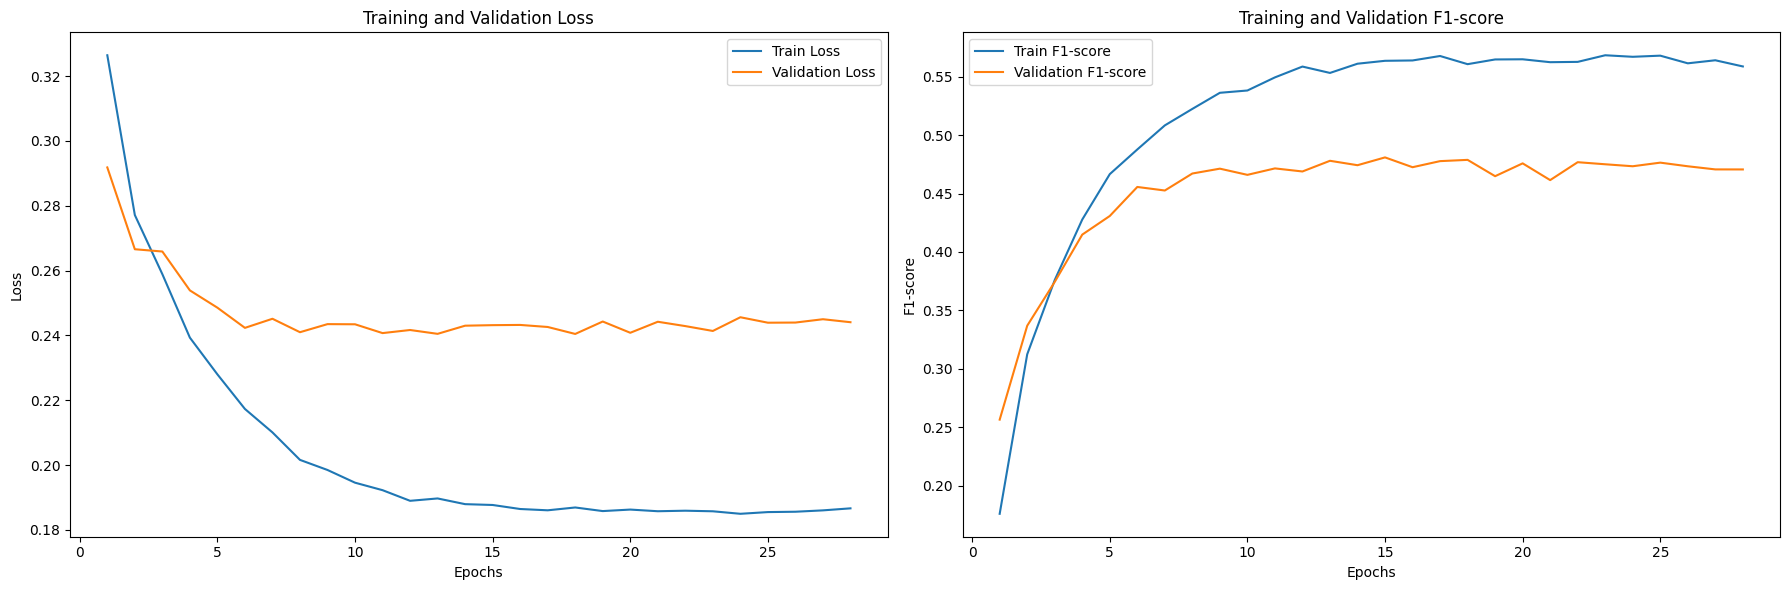

In [51]:
epochs = range(1, epoch + 2)

# Plotting loss and F1-score in subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plotting Loss
axs[0].plot(epochs, train_losses, label='Train Loss')
axs[0].plot(epochs, val_losses, label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plotting F1-score
axs[1].plot(epochs, train_f1_scores, label='Train F1-score')
axs[1].plot(epochs, val_f1_scores, label='Validation F1-score')
axs[1].set_title('Training and Validation F1-score')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('F1-score')
axs[1].legend()

plt.tight_layout()
plt.show()


The training loss decreases steadily over time, and the validation loss also decreases, but more slowly. This indicates that the model is able to learn from the training data and apply that knowledge to new data.

The fact that the validation loss is slightly higher than the training loss and that the Train F1-score is slightly higher than the Validation F1-score suggest that the model may be slightly overfitting to the training data. However, the overfitting is not severe, and the model is still able to generalize well.

Additionally it can be concluded that the training loss and F1-score seems to plateau after about 15 epochs. This suggests that the model may have reached its maximum learning capacity on the training data.

### 8.2 Learning Rate Schedule

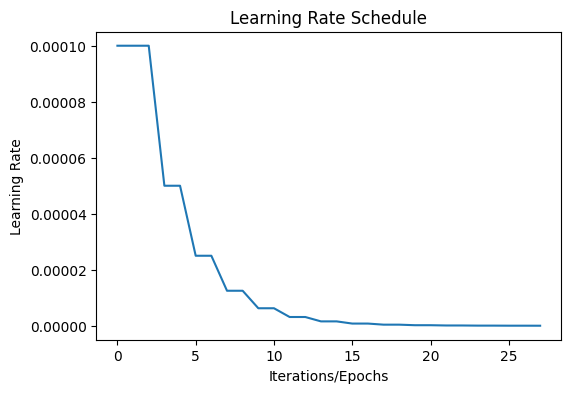

In [52]:
# Plotting learning rate changes over epochs
plt.figure(figsize=(6, 4))
plt.plot(range(len(lr_values)), lr_values)
plt.title('Learning Rate Schedule')
plt.xlabel('Iterations/Epochs')
plt.ylabel('Learning Rate')
plt.show()


This line graph shows the learning rate of the model over the course of training. The learning rate is a parameter that controls how quickly the model updates its weights in response to the training data.

The graph starts with a learning rate of 0.00010 and then decreases steadily to 0.000001 over the course of 25 epochs by multiplying with a factor of 0.5 based on the observed validation loss. This is a common learning rate schedule, as it helps to prevent the model from overfitting the training data and allows it to converge to a better solution.

### 8.3 Confusion Matrix

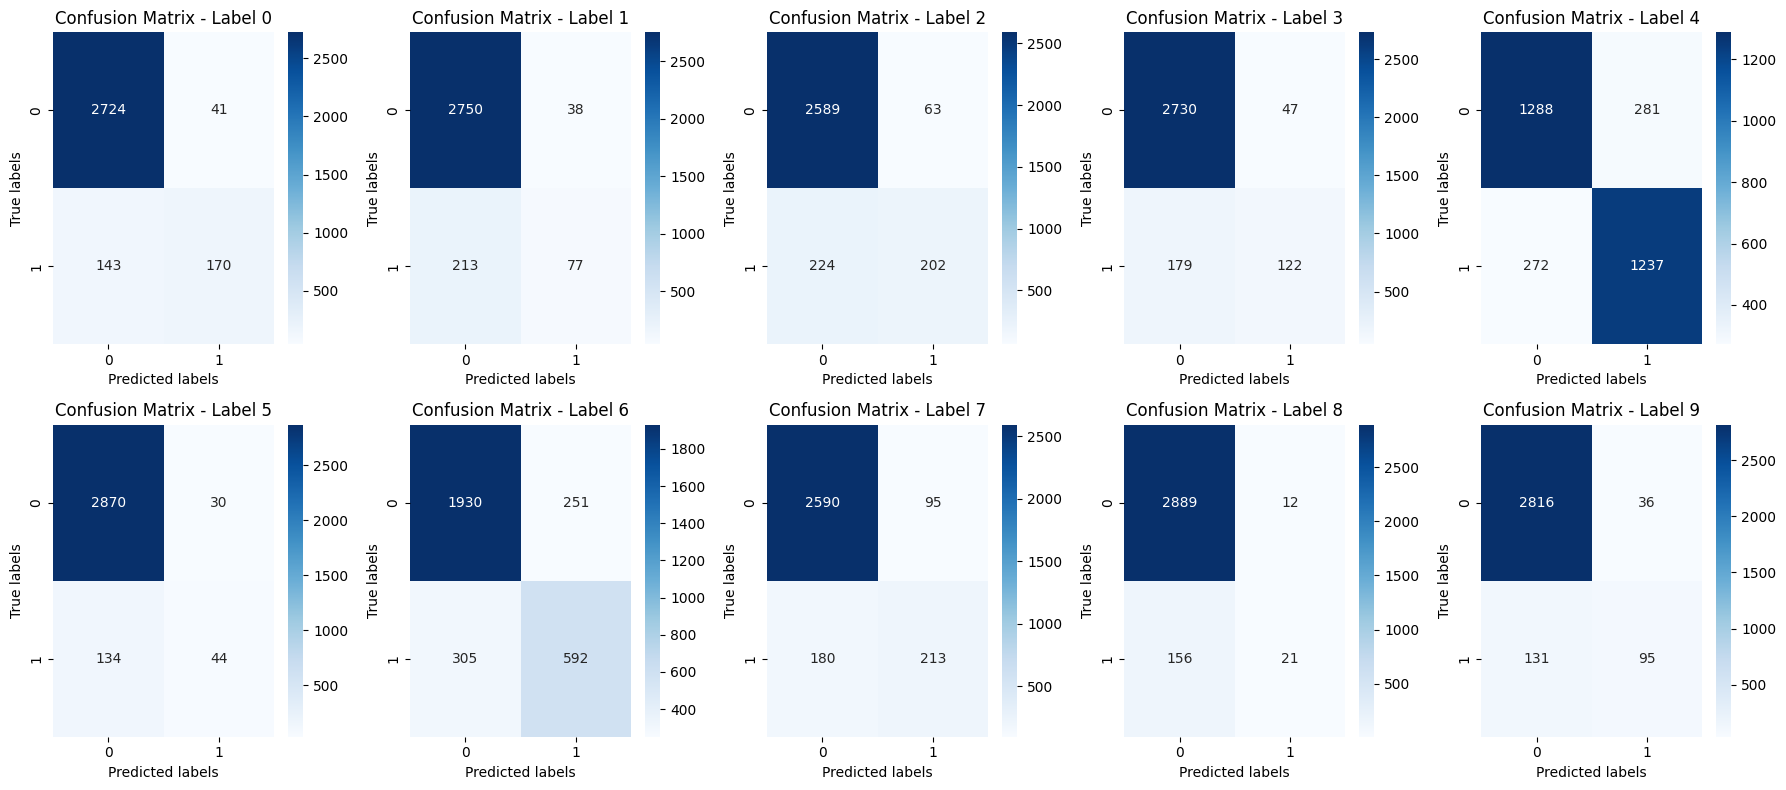

In [61]:
# Calculate multilabel confusion matrix
conf_matrices = multilabel_confusion_matrix(true_labels, predicted_labels)

# Plotting confusion matrices for each label
num_labels = 10
fig, axs = plt.subplots(2, 5, figsize=(18, 8))

for i in range(min(num_labels, len(conf_matrices))):
    row = i // 5
    col = i % 5
    sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Blues', ax=axs[row, col])
    axs[row, col].set_title(f'Confusion Matrix - Label {i}')
    axs[row, col].set_xlabel('Predicted labels')
    axs[row, col].set_ylabel('True labels')

plt.tight_layout()
plt.show()

The confusion matrix shows the counts of true positive, true negative, false positive, and false negative predictions for each class label.

As previously observed in the evaluation metrics, some labels are better predicted than others.

### 8.4 Sample Predictions

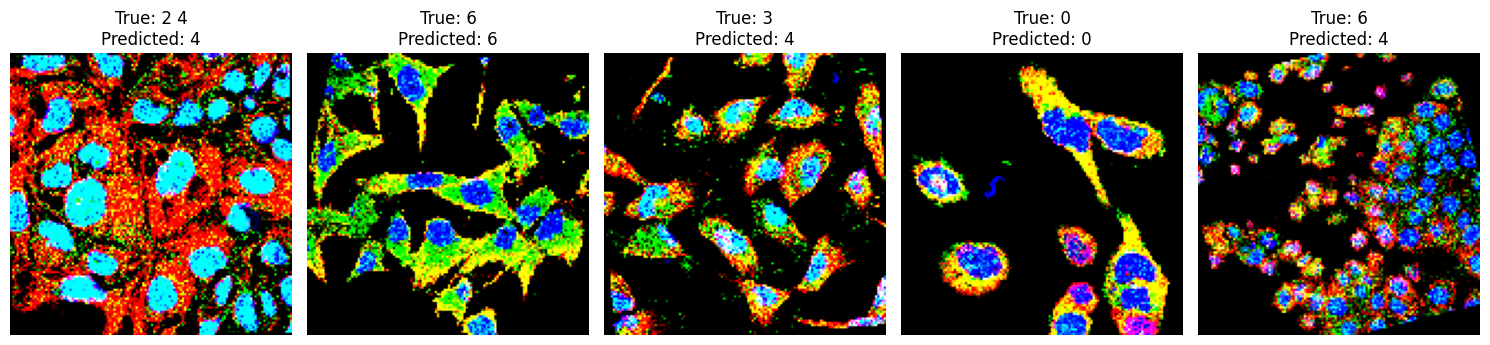

In [34]:
# Function to display images along with true and predicted labels
def display_images_from_batch(images, true_labels, predicted_labels, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].permute(1, 2, 0).cpu())
        plt.title(f"True: {decode_target(true_labels[i])}\nPredicted: {decode_target(predicted_labels[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Fetch a batch from the validation loader
batch_images, batch_labels = next(iter(val_loader))

model.eval()
batch_images = batch_images.to(device)
batch_labels = batch_labels.to(device)
with torch.no_grad():
    outputs = model(batch_images)
    predicted = (outputs > 0.5).float()

# Display the images along with true and predicted labels for the first few images in the batch
display_images_from_batch(batch_images, batch_labels, predicted)


Some of the predictions along with their respective transformed images are represented here. The RGB normalizations are notably visible and their importance becomes visibly clear.

## 9. OPTIONAL: Calibration assessment

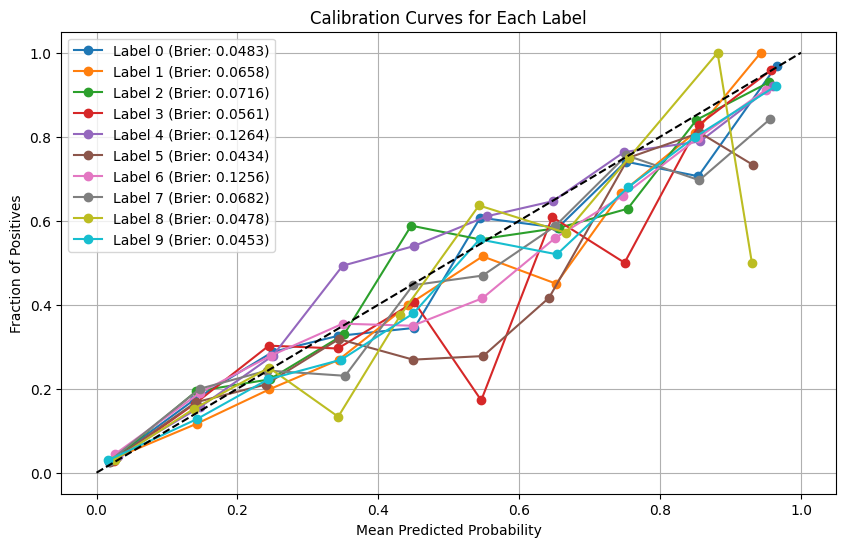

In [38]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt
import numpy as np

true_labels_array = np.stack(true_labels)
predicted_labels_array = np.stack(predicted_probs)

# Calculate Brier scores for each label
brier_scores = []
for label_idx in range(10):  # Iterate through each label
    brier_score = brier_score_loss(true_labels_array[:, label_idx], predicted_labels_array[:, label_idx])
    brier_scores.append(brier_score)

plt.figure(figsize=(10, 6))
for label_idx in range(10):  # Iterate through each label
    prob_true, prob_pred = calibration_curve(true_labels_array[:, label_idx], predicted_labels_array[:, label_idx], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f'Label {label_idx} (Brier: {brier_scores[label_idx]:.4f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='black')  # Perfectly calibrated line
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curves for Each Label')
plt.legend()
plt.grid(True)
plt.show()


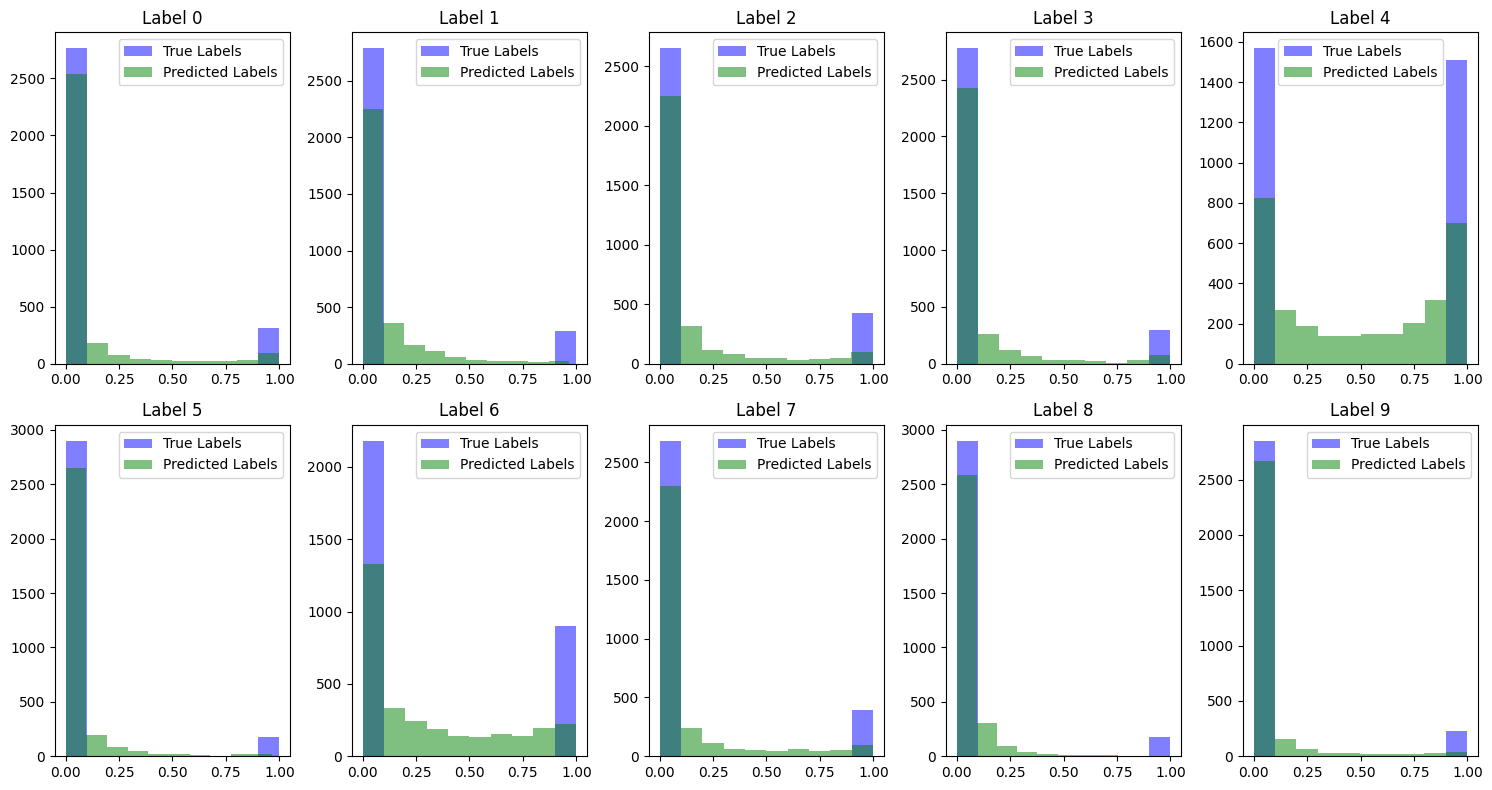

In [62]:
# Define the size of the plot grid
num_rows = 2
num_cols = 5

# Create a grid of histograms for true and predicted labels
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 8))

label_idx = 0
for i in range(num_rows):
    for j in range(num_cols):
        if label_idx < 10:
            axs[i, j].hist(true_labels_array[:, label_idx], alpha=0.5,color ="blue" ,label='True Labels')
            axs[i, j].hist(predicted_labels_array[:, label_idx], alpha=0.5, color = 'green', label='Predicted Labels')
            axs[i, j].set_title(f"Label {label_idx}")
            axs[i, j].legend()
            label_idx += 1
        else:
            break

plt.tight_layout()
plt.show()

# 10. CSV file

In [ ]:
# Predictions for the test set

test_dataset = ProteinDataset(
    test_df, data_dir=test_data_dir, transform=transforms_train, mode="test"
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# Make predictions for the test images
model.eval()
predictions = []

with torch.no_grad():
    for inputs, img_names in test_loader:
        inputs = inputs.to(device)
        img_names = img_names.to(device)

        outputs = model(inputs)

        # Apply threshold for binary predictions
        threshold = 0.5
        predicted = (outputs > threshold).squeeze().cpu().numpy().astype(int)

        # Convert predictions to label format
        predicted_labels = " ".join([str(i) for i in np.where(predicted == 1)[0]])

        # Append image names and predicted labels to list
        predictions.append((img_names[0].item(), predicted_labels))

# Write predictions to sub.csv
submission_df = pd.DataFrame(predictions, columns=["Image", "Label"])
submission_df.to_csv("sub.csv", index=False)